In [20]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Fetch BTC trade raw data
today = datetime.date.today()
BTC_raw = yf.download('BTC-USD', start=today-datetime.timedelta(days=700), end=today)
# BTC_raw.columns = ['date', 'open_price', 'high', 'low', 'close_price', 'adj close', 'volume']
BTC_raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,55200191952
2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335
2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921
2021-05-31,35658.593750,37468.250000,34241.945312,37332.855469,37332.855469,39009847639
2021-06-01,37293.792969,37896.734375,35787.085938,36684.925781,36684.925781,34639423297


In [23]:
# Split the raw data into parts
BTC_basic = BTC_raw[['Adj Close', 'Open']]
BTC_quant = BTC_raw
BTC_quant

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,55200191952
2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335
2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921
2021-05-31,35658.593750,37468.250000,34241.945312,37332.855469,37332.855469,39009847639
2021-06-01,37293.792969,37896.734375,35787.085938,36684.925781,36684.925781,34639423297
...,...,...,...,...,...,...
2023-04-22,27265.894531,27872.142578,27169.570312,27817.500000,27817.500000,13125734602
2023-04-23,27816.144531,27820.244141,27400.314453,27591.384766,27591.384766,12785446832
2023-04-24,27591.730469,27979.982422,27070.849609,27525.339844,27525.339844,17703288330


Text(0, 0.5, 'Prices ($)')

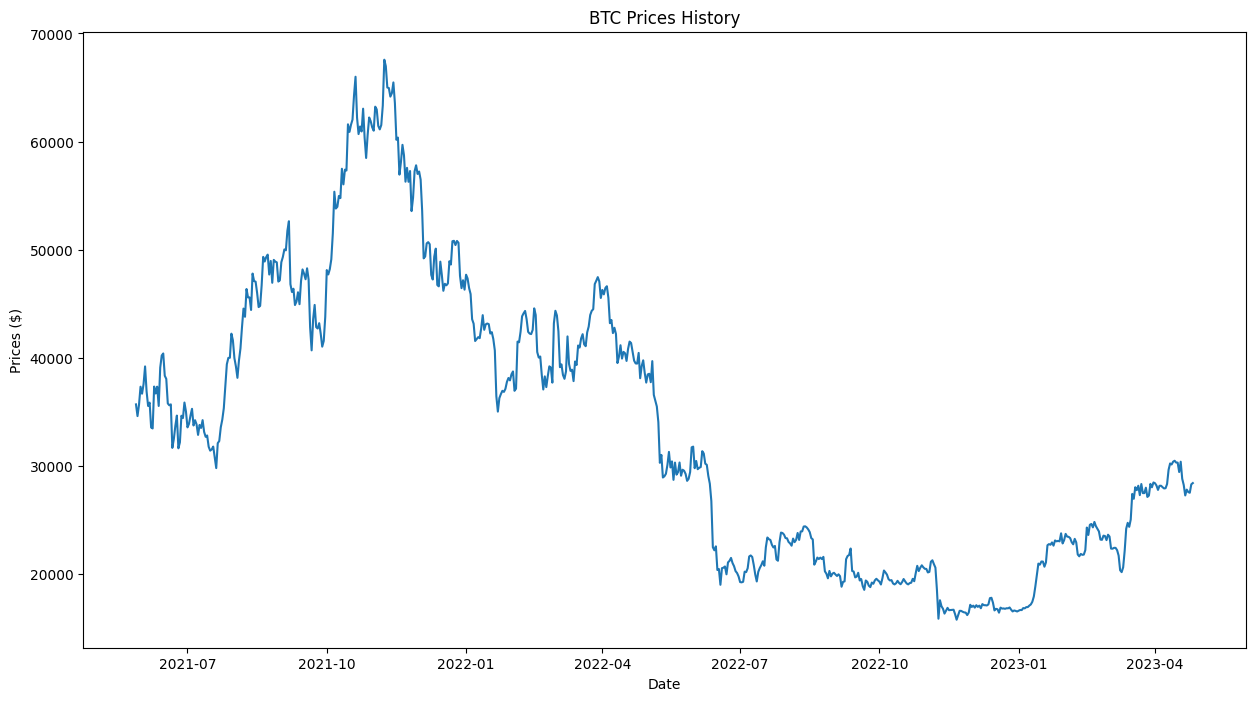

In [24]:
plt.figure(figsize=(15, 8))
plt.title('BTC Prices History')
plt.plot(BTC_quant['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [25]:
### Preparing training set (80%) ###
x_train = []
y_train = []
# Extract close price
close_price = BTC_quant['Adj Close']
training_data_len = math.ceil(len(close_price.values)* 0.8)
# Normalised data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.values.reshape(-1,1))
training_data = scaled_data[0: training_data_len, :]

In [26]:
training_data

array([[0.38452099],
       [0.3636336 ],
       [0.38414484],
       [0.41610199],
       [0.40358875],
       [0.42078191],
       [0.45233078],
       [0.40763438],
       [0.38170813],
       [0.3877032 ],
       [0.34325182],
       [0.34155088],
       [0.41633887],
       [0.40393004],
       [0.41613179],
       [0.38171892],
       [0.45018889],
       [0.47183097],
       [0.47545775],
       [0.43568901],
       [0.43001962],
       [0.38625218],
       [0.38294248],
       [0.38453434],
       [0.30686653],
       [0.32287608],
       [0.34638666],
       [0.36452915],
       [0.306115  ],
       [0.31670795],
       [0.36428209],
       [0.36012391],
       [0.38780746],
       [0.37183703],
       [0.34347218],
       [0.34974744],
       [0.36464714],
       [0.3766062 ],
       [0.3468304 ],
       [0.35627798],
       [0.34894174],
       [0.3300548 ],
       [0.3478348 ],
       [0.3424757 ],
       [0.35637439],
       [0.33543292],
       [0.32666841],
       [0.328

In [27]:
### Create a price window with 30 days ###
window_size = 30
for i in range(window_size, len(training_data)):
    x_train.append(training_data[i-window_size:i, 0])
    y_train.append(training_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
### Preparing testing set (20%) ###
test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = close_price.values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
x_test

array([[[0.00180566],
        [0.03475286],
        [0.02408304],
        ...,
        [0.02514931],
        [0.02048768],
        [0.02792976]],

       [[0.03475286],
        [0.02408304],
        [0.01954249],
        ...,
        [0.02048768],
        [0.02792976],
        [0.02599228]],

       [[0.02408304],
        [0.01954249],
        [0.01093252],
        ...,
        [0.02792976],
        [0.02599228],
        [0.02590676]],

       ...,

       [[0.22610131],
        [0.23575036],
        [0.21924883],
        ...,
        [0.22189508],
        [0.2323353 ],
        [0.22796842]],

       [[0.23575036],
        [0.21924883],
        [0.22172553],
        ...,
        [0.2323353 ],
        [0.22796842],
        [0.22669291]],

       [[0.21924883],
        [0.22172553],
        [0.24258918],
        ...,
        [0.22796842],
        [0.22669291],
        [0.24180038]]])

In [79]:
### Set up LSTM architecture ###
model = keras.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Introduce dropout to avoid over-fit
model.add(layers.Dropout(0.21))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.18))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_18 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_19 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [80]:
### Traning ###
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True), loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=100)
model.save(f'/content/drive/MyDrive/ELEN-E6889/LSTM_model.h5')

Epoch 1/100
17/17 [==============================] - 5s 10ms/step - loss: 0.0459
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0067
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0074
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0054
Epoch 9/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 10/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 11/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 12/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 13/100
17/17 [==============

In [81]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 1s 7ms/step


271.30985836330933

<ipython-input-82-7eb5587c3d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


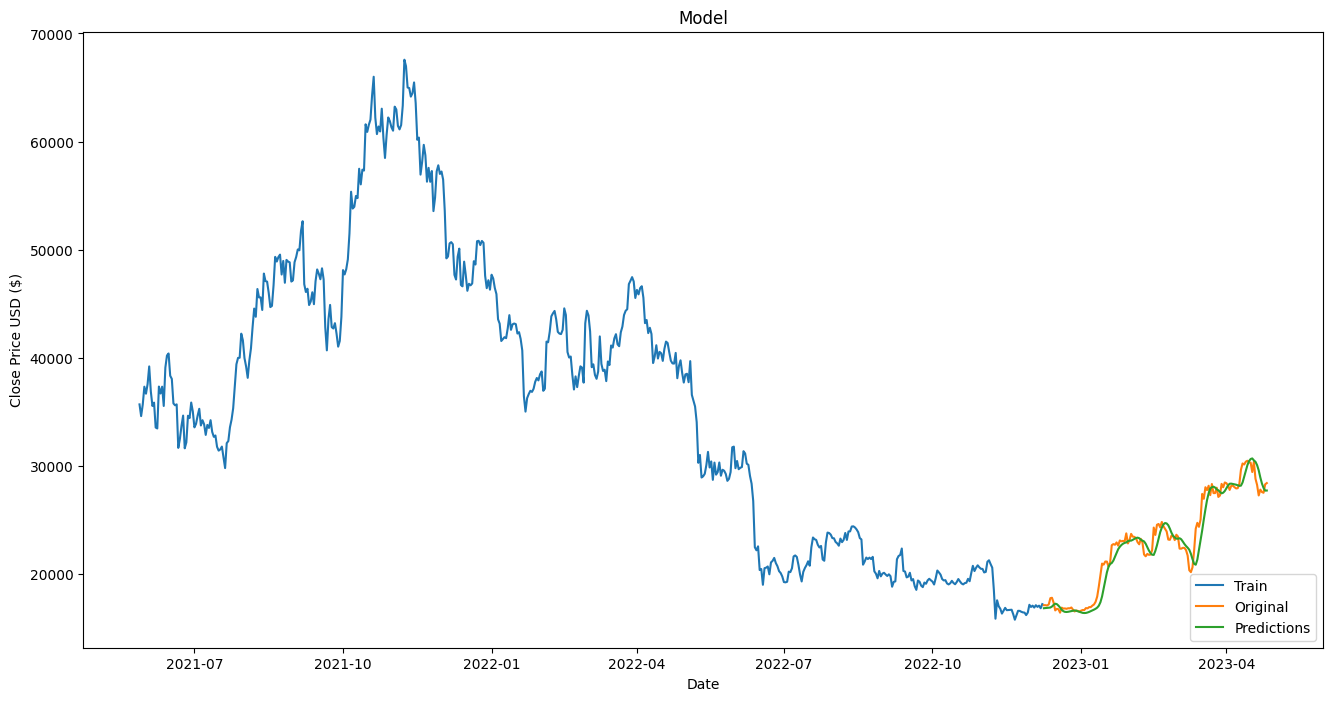

In [82]:
data = BTC_quant.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Original', 'Predictions'], loc='lower right')
plt.savefig('./LSTM_Result.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
## Predict tommorrow price ##
stock_quote = yf.download('BTC-USD', start='2021-01-01', end='2023-04-19')

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of BTC-USD tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 1s 909ms/step
Price of BTC-USD tomorrow:[[30658.574]]


In [71]:
def predict_and_plot_btc_prices(num_days_to_predict):
  today = datetime.date.today()
  stock_quote = yf.download('BTC-USD', start=today-datetime.timedelta(days=365), end=today)
  new_df=stock_quote.filter(['Close'])
  last_60_days = new_df[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  predictions = []
  predicted_dates = []
  for _ in range(num_days_to_predict):
    last_date = new_df.index[-1]
    # Create an empty list for the current iteration
    X_test = []
    # Append the past 60 days of scaled data
    X_test.append(last_60_days_scaled)
    # Convert the X_test data into a numpy array
    X_test = np.array(X_test)
    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Get the predicted scaled price
    pred_price = model.predict(X_test)
    # Undo the scaling
    pred_price_unscaled = scaler.inverse_transform(pred_price)
    # Add the unscaled predicted price to the list of predictions
    predictions.append(pred_price_unscaled[0][0])
    # Update last_60_days_scaled by removing the first day and adding the predicted price
    last_60_days_scaled = np.concatenate((last_60_days_scaled[1:], pred_price), axis=0)
    # Add the predicted date to the list of predicted_dates
    predicted_date = last_date + datetime.timedelta(days=_+1)
    predicted_dates.append(predicted_date)
  print(f"Price of BTC-USD for the next 3 trading days: {predictions}")
  fig, ax = plt.subplots()
  ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
  ax.set(xlabel='Date', ylabel='BTC-USD Price', title=f'Predicted BTC-USD Prices for the Next {num_days_to_predict} Trading Days')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
  ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=5))
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.savefig(f'./Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
  plt.show()

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 19ms/step
Price of BTC-USD for the next 3 trading days: [28027.678]


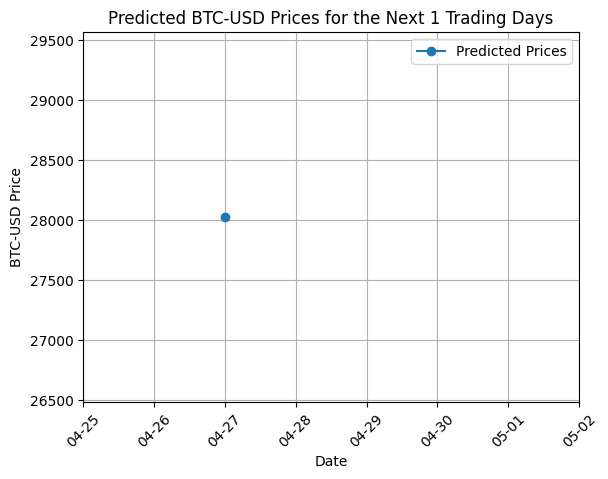

In [72]:
predict_and_plot_btc_prices(1)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
Price of BTC-USD for the next 3 trading days: [28027.678, 28193.805, 28357.805]


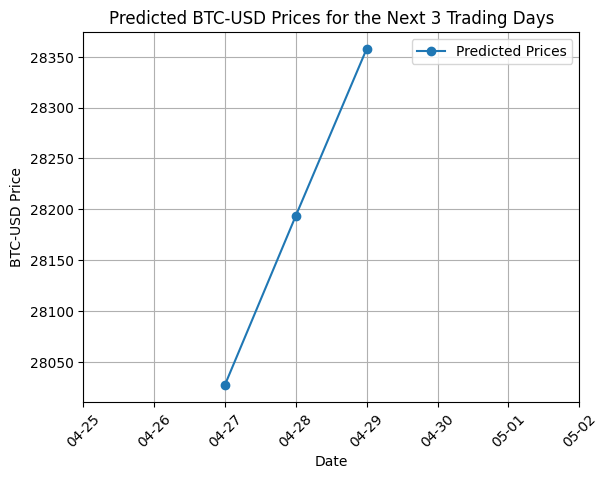

In [73]:
predict_and_plot_btc_prices(3)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 33ms/step
Price of BTC-USD for the next 3 trading days: [28027.678, 28193.805, 28357.805, 28510.332, 28654.66]


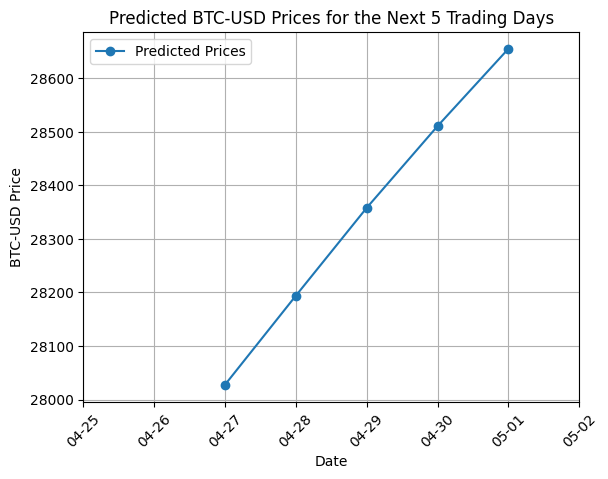

In [74]:
predict_and_plot_btc_prices(5)